In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import KFold
import pandas as pd
%matplotlib inline

In [2]:
class Loss(object):
    
    def __call__(self, predicted, actual):
        """Calculates the loss as a function of the prediction and the actual.
        
        Args:
          predicted (np.ndarray, float): the predicted output labels
          actual (np.ndarray, float): the actual output labels
          
        Returns: (float) 
          The value of the loss for this batch of observations.
        """
        raise NotImplementedError
        
    def derivative(self, predicted, actual):
        """The derivative of the loss with respect to the prediction.
        
        Args:
          predicted (np.ndarray, float): the predicted output labels
          actual (np.ndarray, float): the actual output labels
          
        Returns: (np.ndarray, float) 
          The derivatives of the loss.
        """
        raise NotImplementedError
        
        
class SquaredErrorLoss(Loss):
    
    def __call__(self, predicted, actual):
        return 0.5*np.sum(
            np.multiply((predicted - actual), (predicted - actual))
        )
    
    def delta(self, z_prime, predicted, actual):
        return (
            np.multiply((predicted - actual), z_prime.T)
        )

class crossEntropy(Loss):
    
    def __call__(self, predicted, actual):
        return np.sum(
            np.nan_to_num(np.multiply(-actual,np.log(predicted))-np.multiply((1-actual),np.log(1-predicted)))
        )
    
    def delta(self, z_prime, predicted, actual):
        return (
            (predicted-actual)
        )

In [3]:
class ActivationFunction(object):
        
    def __call__(self, a):
        """Applies activation function to the values in a layer.
        
        Args:
          a (np.ndarray, float): the values from the previous layer (after 
            multiplying by the weights.
          
        Returns: (np.ndarray, float) 
          The values h = g(a).
        """
        return a
    
    def derivative(self, h):
        """The derivatives as a function of the outputs at the nodes.
        
        Args:
          h (np.ndarray, float): the outputs h = g(a) at the nodes.
          
        Returns: (np.ndarray, float) 
          The derivatives dh/da.
        """
        return np.ones(h.shape)
    
class ReLU(ActivationFunction):
    
    def __call__(self, a):
        return np.where(a > 0, a, 0)
    
    def derivative(self, a):
        return np.where(a > 0, 1, 0)

class Sigmoid(ActivationFunction):
    
    def __call__(self, a):
        return 1/(1 + np.exp(-a))
    
    def derivative(self, a):
        e = self.__call__(a)
        return  np.multiply(e, (1 - e))

In [4]:
class Layer(object):
    """A data structure for a layer in a neural network.
    
    Attributes:
      num_nodes (int): number of nodes in the layer
      activation_function (ActivationFunction)
      values_pre_activation (np.ndarray, float): most recent values
        in layer, before applying activation function
      values_post_activation (np.ndarray, float): most recent values
        in layer, after applying activation function
    """
    
    def __init__(self, num_nodes, activation_function=ActivationFunction()):
        self.num_nodes = num_nodes
        self.activation_function = activation_function
        
    def get_layer_values(self, values_pre_activation):
        """Applies activation function to values from previous layer.
        
        Stores the values (both before and after applying activation 
        function)
        
        Args:
          values_pre_activation (np.ndarray, float): 
            A (batch size) x self.num_nodes array of the values
            in layer before applying the activation function
        
        Returns: (np.ndarray, float)
            A (batch size) x self.num_nodes array of the values
            in layer after applying the activation function
        """
        self.values_pre_activation = values_pre_activation
        self.values_post_activation = self.activation_function(
            values_pre_activation
        )
        return self.values_post_activation
    
    def get_layer_derivatives(self, values_pre_activation):
        return self.activation_function.derivative(
            values_pre_activation
        )

In [271]:
class FullyConnectedNeuralNetwork(object):
    """A data structure for a fully-connected neural network.
    
    Attributes:
      layers (Layer): A list of Layer objects.
      loss (Loss): The loss function to use in training.
      learning_rate (float): The learning rate to use in backpropagation.
      weights (list, np.ndarray): A list of weight matrices,
        length should be len(self.layers) - 1
      biases (list, float): A list of bias terms,
        length should be equal to len(self.layers)
    """
    
    def __init__(self, layers, loss, learning_rate):
        self.layers = layers
        self.loss = loss
        self.learning_rate = learning_rate
        
        # initialize weight matrices and biases to zeros
        self.weights = []
        self.biases = []
        mu, sigma = 0, 1
        for i in range(1, len(self.layers)):
            w = np.matrix(np.random.normal(mu, sigma, (self.layers[i - 1].num_nodes, self.layers[i].num_nodes))/np.sqrt(self.layers[i - 1].num_nodes))
            self.weights.append(w)
            self.biases.append(np.zeros(self.layers[i].num_nodes))
        
    def feedforward(self, inputs):
        """Predicts the output(s) for a given set of input(s).
        
        Args:
          inputs (np.ndarray, float): A (batch size) x self.layers[0].num_nodes array
          
        Returns: (np.ndarray, float) 
          An array of the predicted output labels, length is the batch size
        """
        self.storedValuesZ = [inputs]
        self.storedValuesA = [inputs]
        a = inputs
        
        ## Iterate layers
        for i, layer in enumerate(self.layers):
            ## g(hw + b),  h = previous layer values
            if i != len(self.layers) - 1:
                z = np.matrix(np.add(a * self.weights[i], np.matrix(self.biases[i])))
                self.storedValuesZ.append(z)
                a = np.matrix(self.layers[i + 1].get_layer_values(z))
                self.storedValuesA.append(a)
        return a
    
    def predict(self, inputs):
        h = inputs
        ## Iterate layers
        for i, layer in enumerate(self.layers):
            ## g(hw + b),  h = previous layer values
            if i != len(self.layers) - 1:
                a = np.matrix(np.add(h * self.weights[i], np.matrix(self.biases[i])))
                h = self.layers[i+1].get_layer_values(a)
        return h
    
    def backProp(self, predicted, actual):
        gradient_b = [np.zeros(b.shape) for b in self.biases]
        gradient_w = [np.zeros(w.shape) for w in self.weights]
        # Update First weights
        z_prime = 0
        if (type(self.loss) == type(SquaredErrorLoss())):
            z_prime = self.layers[-1].get_layer_derivatives(self.storedValuesZ[-1]).T
        delta = self.loss.delta(z_prime, predicted, actual).T
        dLdw = np.multiply(delta,self.storedValuesA[-2]).T
        
        gradient_b[-1] = delta.T
        gradient_w[-1] = dLdw
        #self.updatedWeights[-1]= self.weights[-1] - self.learning_rate * dLdw
        #self.updatedBiases[-1] = self.biases[-1] - np.multiply(self.learning_rate, delta).T
        
        # Update rest of the weights
        for l in range(2, len(self.layers)):
            z = self.storedValuesZ[-l]
            dadz = self.layers[-l].get_layer_derivatives(z)
            delta = np.multiply(self.weights[-l + 1] * delta, dadz.T)
            dLdw = np.multiply(delta, self.storedValuesA[-l - 1]).T
            gradient_b[-l] = delta.T
            gradient_w[-l] = dLdw
            #self.updatedBiases[-l] = self.biases[-l] - np.multiply(self.learning_rate, delta).T
            #self.updatedWeights[-l] = self.weights[-l] - np.multiply(self.learning_rate, np.dot(delta, self.storedValuesA[-l - 1])).T
        return (gradient_b, gradient_w)
        
    def train(self, inputs, labels):
        """Trains neural network based on a batch of training data.
        
        Args:
          inputs (np.ndarray): A (batch size) x self.layers[0].num_nodes array
          labels (np.ndarray): An array of ground-truth output labels, 
            length is the batch size.
        """
        predicted = self.feedforward(inputs)
        gradient_b, gradient_w = self.backProp(predicted, labels)
        return (gradient_b, gradient_w, self.loss(predicted,labels))
    
    def train_epochs_minibatch(self, inputs, labels, epochs = 10, mini_batch=1):
        '''
        Args:
          inputs (np.ndarray): A x self.layers[0].num_nodes array
          labels (np.ndarray): An array of ground-truth output labels, 
            length is the inputs size.
          epochs (int): Number of times the data is iterated through
          mini_batch (int): Number of observations to train at a time
        '''
        if (inputs.shape[0] < mini_batch):
            mini_batch = inputs.shape[0]
        meanLossEpochs = []
        for i in range(epochs):
            print('Epoch#:',i)
            sum_gradient_b = [np.zeros(b.shape) for b in self.biases]
            sum_gradient_w = [np.zeros(w.shape) for w in self.weights]
            sumLoss = 0
            randomIndices = np.random.choice([i for i in range(len(inputs))], size=inputs.shape[0], replace=False)
            for index, row in enumerate(randomIndices):
                gradient_b, gradient_w, loss = self.train(np.matrix([inputs[row]]),np.matrix([labels[row]]))
                sumLoss += loss
                sum_gradient_b = [sb+gb for sb, gb in zip(sum_gradient_b,gradient_b)]
                sum_gradient_w = [sw+gw for sw, gw in zip(sum_gradient_w, gradient_w)]
                if ((index+1)%mini_batch == 0 or (index+1) == inputs.shape[0]):
                    self.biases = [b-(self.learning_rate/mini_batch)*sb
                                      for b, sb in zip(self.biases, sum_gradient_b)]
                    self.weights = [w-(self.learning_rate/mini_batch)*sw
                                     for w, sw in zip(self.weights, sum_gradient_w)]
                    sum_gradient_b = [np.zeros(b.shape) for b in self.biases]
                    sum_gradient_w = [np.zeros(w.shape) for w in self.weights]
            avg_loss = sumLoss/inputs.shape[0]
            meanLossEpochs.append(avg_loss)
        return (meanLossEpochs)

In [276]:
# Sigmoid must be applied to the last layer inorder for it to work
network = FullyConnectedNeuralNetwork(
    layers=[Layer(1), Layer(2, ReLU()), Layer(5, Sigmoid())],
    loss = crossEntropy(),
    learning_rate=0.005
)

In [109]:
test = pd.read_csv("train.csv")

In [210]:
test.head()

,ABV,appearance,aroma,overall,palate,taste,userBias,word_count,char_count,avg_word_len,...,Spain,Sri Lanka,Sweden,Switzerland,"Taiwan, Province of China",Thailand,Togo,United Kingdom,United States,Location Unknown
0,0.092014,0.7,0.750,1.0,0.750,0.875,0.745000,0.135593,0.135916,0.312620,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.192708,0.8,1.000,1.0,1.000,1.000,0.766250,0.238418,0.232877,0.270866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.111111,0.8,0.875,1.0,0.875,0.875,0.775000,0.114124,0.119221,0.425918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.123264,0.8,0.875,1.0,0.750,0.875,0.711000,0.213559,0.221747,0.344344,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.175347,0.8,0.875,1.0,0.875,0.875,0.755556,0.211299,0.209332,0.288806,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [277]:
dependents = ['appearance','aroma','overall','palate','taste']

In [117]:
independents = []
for x in list(test.columns):
    if (x not in dependents):
        independents.append(x)

In [263]:
independents = ['userBias']

In [44]:
def makeXandY(data, dependentNames, independentName, intercept):
    X = np.array(data[dependentNames])
    if (intercept):
        X = np.insert(X, 0, 1, axis=1)
    y = np.array(data[independentName])
    return X, y

In [278]:
x, y = makeXandY(test, independents, dependents, False)

In [279]:
x.shape

(37500, 1)

In [280]:
y.shape

(37500, 5)

In [292]:
testX = x[:100]
testY = y[:100]
trainX = x[100:1000]
trainY = y[100:1000]

In [294]:
epochsMeanError = network.train_epochs_minibatch(trainX, trainY, epochs=10, mini_batch=1)

Epoch#: 0
Epoch#: 1
Epoch#: 2
Epoch#: 3
Epoch#: 4
Epoch#: 5
Epoch#: 6
Epoch#: 7
Epoch#: 8
Epoch#: 9


In [283]:
testY

array([ 0.7  ,  0.75 ,  1.   ,  0.75 ,  0.875])

In [295]:
network.predict(testX)

matrix([[ 0.87259022,  0.87222825,  0.99930779,  0.88324609,  0.92021554],
        [ 0.87500957,  0.87464701,  0.99938885,  0.88613176,  0.92322206],
        [ 0.87599428,  0.87563151,  0.99941941,  0.8873018 ,  0.92442958],
        [ 0.86863616,  0.86827545,  0.99915517,  0.8784971 ,  0.91518099],
        [ 0.87379695,  0.87343466,  0.99934932,  0.88468735,  0.92172219],
        [ 0.89432632,  0.89396461,  0.99979188,  0.90858118,  0.94517911],
        [ 0.87831202,  0.87794889,  0.99948615,  0.89004542,  0.92723474],
        [ 0.87649411,  0.87613125,  0.9994344 ,  0.8878947 ,  0.92503893],
        [ 0.87976745,  0.87940416,  0.99952457,  0.89176074,  0.92896956],
        [ 0.87027677,  0.86991549,  0.99922172,  0.88047241,  0.91728805],
        [ 0.88934728,  0.88898435,  0.99972099,  0.90290018,  0.93987089],
        [ 0.86897613,  0.8686153 ,  0.99916935,  0.87890699,  0.91561973],
        [ 0.89674101,  0.89638015,  0.99982026,  0.91130814,  0.94766473],
        [ 0.87302687,  0.

In [291]:
# Predict to find error
network.predict(testX)

matrix([[ 0.66339757,  0.7132823 ,  0.97382122,  0.73408313,  0.8735975 ]])

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
xs = np.arange(50)

Text(0.5,1,'Cross Entropy Loss Function')

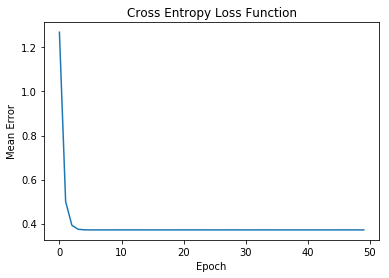

In [38]:
plt.plot(xs,epochsMeanError)
plt.xlabel('Epoch')
plt.ylabel('Mean Error')
plt.title("Cross Entropy Loss Function")

Text(0.5,1,'Squared Error Loss Function')

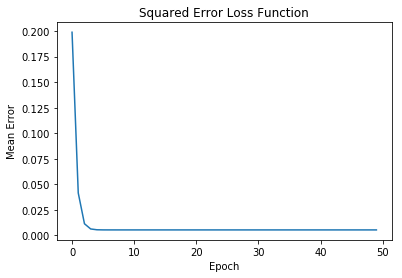

In [35]:
plt.plot(xs,epochsMeanError)
plt.xlabel('Epoch')
plt.ylabel('Mean Error')
plt.title("Squared Error Loss Function")